In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
from tqdm.notebook import tqdm
from torchsummary import summary
from torchvision import datasets
from torchvision import transforms


from utils import read_machine_data_cvae
from utils import softclip
from utils import plot_train_test_reconstructions, plot_train_test_reconstructions_cvae
from models.cnn_sigmacVAE import CNN_sigmacVAE

import evaluation_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [3]:
window_size = 24
cond_window_size = 8
batch_size=256

X_train_data, X_test_data, X_train_tensor, cond_train_tensor, X_test_tensor, cond_test_tensor, df_Y_test, trainloader, testloader = read_machine_data_cvae('../../datasets/ServerMachineDataset/machine-1-1', window_size, cond_window_size, batch_size)

In [4]:
def train_model(model, num_epochs, learning_rate, dataloader):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epochs=num_epochs
    tq = tqdm(range(epochs))
    for epoch in tq:
        flag = False
        for j, data in enumerate(dataloader, 0):

            model.train()
            
            optimizer.zero_grad()

            #batches
            inputs, cond = data
            inputs = inputs.cuda() if torch.cuda.is_available() else inputs.cpu()
            inputs.to(device)
            cond = cond.cuda() if torch.cuda.is_available() else cond.cpu()
            cond.to(device)

            outputs, rec_mu, rec_sigma, kl = model(inputs, cond)

            rec_comps, rec, rec_mu_sigma_loss, kl = model.loss_function(outputs, inputs, rec_mu, rec_sigma, kl)

            loss = rec + kl + rec_mu_sigma_loss

            if(np.isnan(loss.item())):
                print("Noped out at", epoch, j, kl, rec_comps)
                flag = True
                break

            loss.backward()
            optimizer.step()
        if(flag):
            break
        tq.set_postfix(loss=loss.item())
        #print(epoch, 'total :' + str(loss.item()) + ' rec : ' + str(rec.item()) + ' kl : ' + str(kl.sum().item()) + ' sigma: ' + str(model.log_sigma.item()))

        #break
    return model

In [5]:
latent_dim=8
model = CNN_sigmacVAE(latent_dim=latent_dim, window_size=window_size, cond_window_size=cond_window_size, use_probabilistic_decoder=False)
model.to(device)
model.cuda() if torch.cuda.is_available() else model.cpu()

model = train_model(model, 5, .005, trainloader)

In [6]:
torch.save(model, 'cvae2d.pth')

In [7]:
print(X_train_data.shape)

(28479, 38)


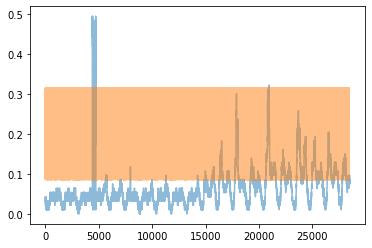

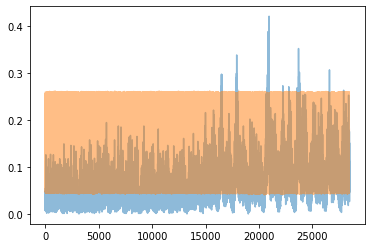

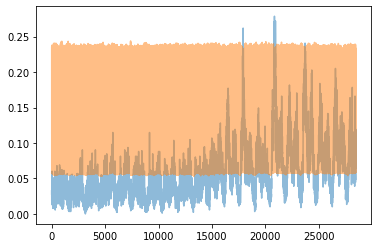

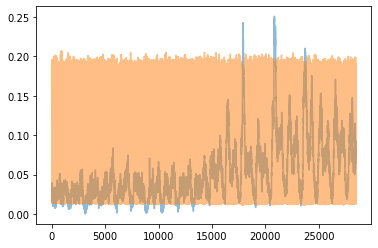

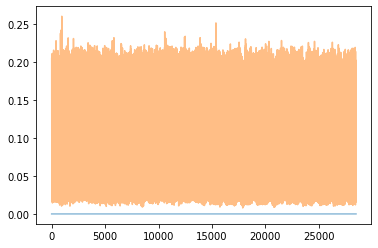

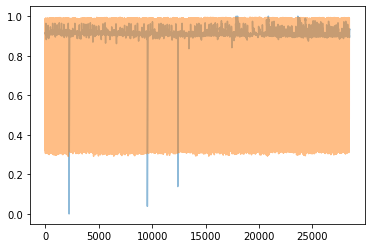

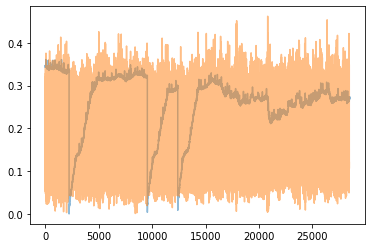

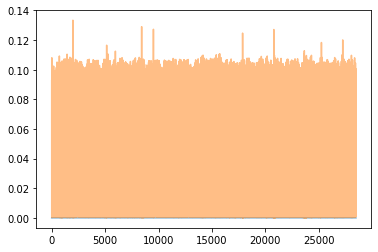

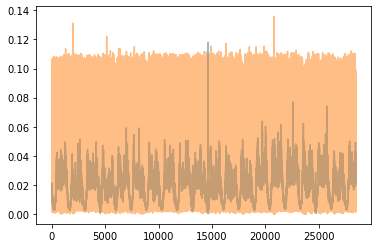

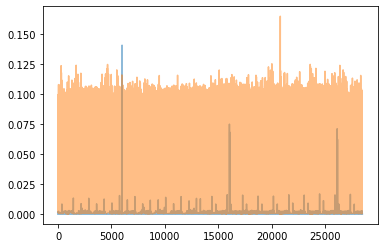

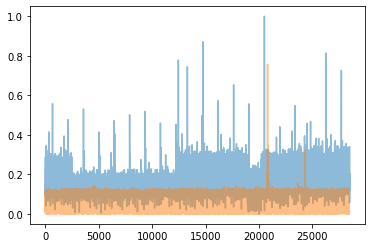

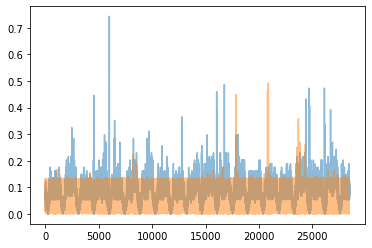

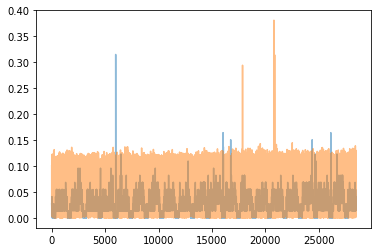

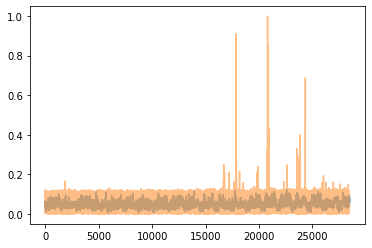

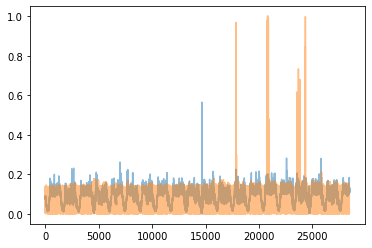

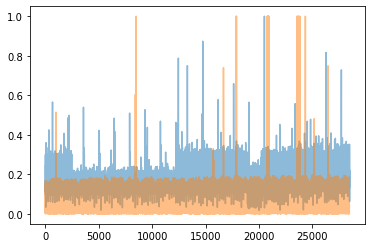

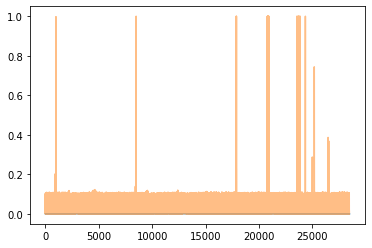

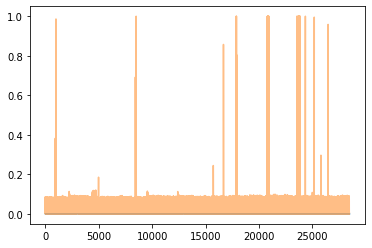

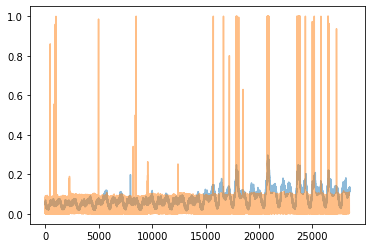

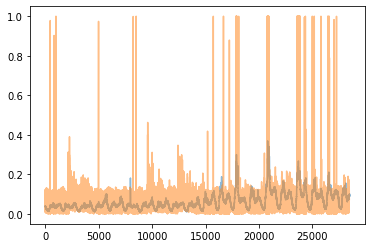

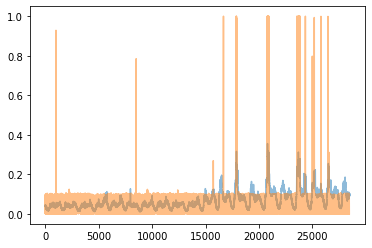

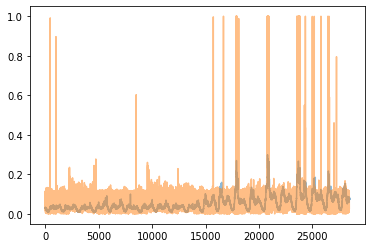

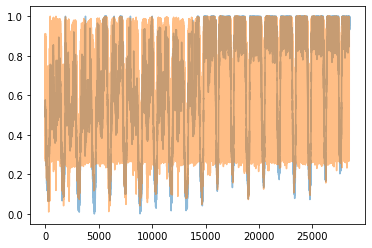

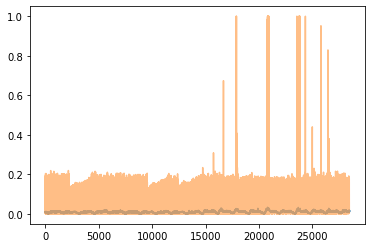

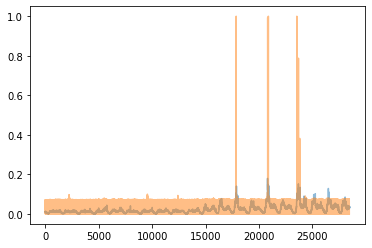

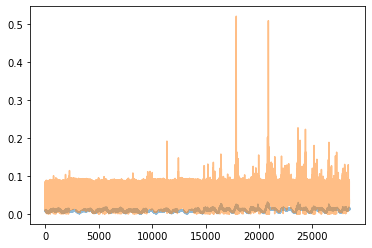

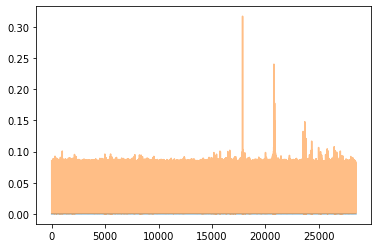

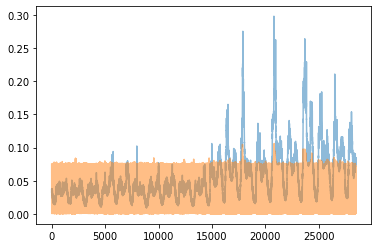

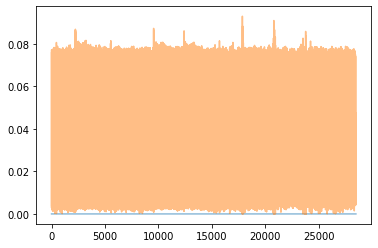

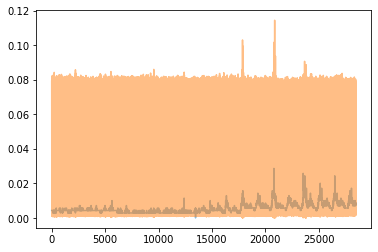

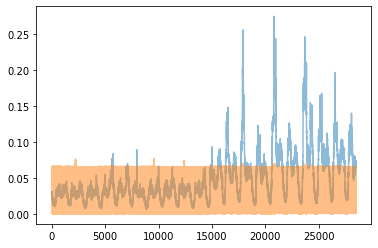

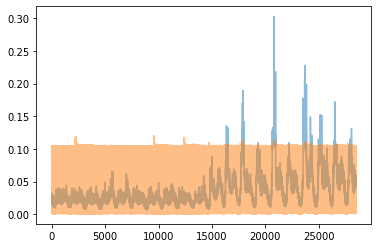

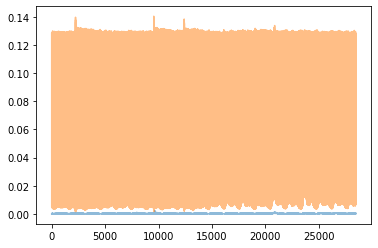

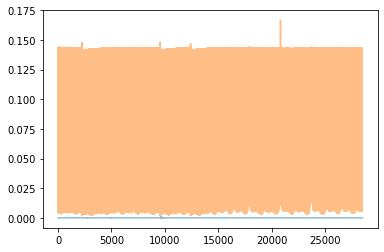

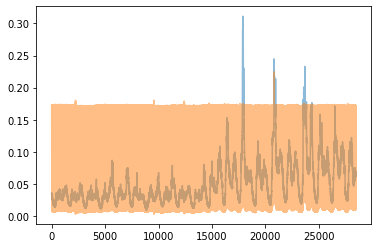

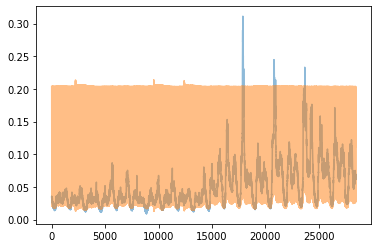

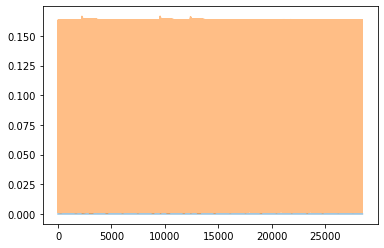

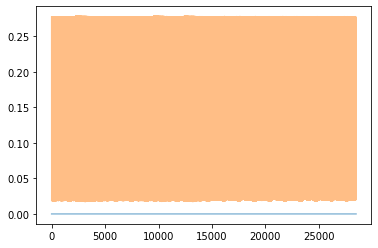

MSE : 0.00962


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\python37\lib\site-packages\IPython\core\interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-a7fd8259d838>", line 1, in <module>
    plot_train_test_reconstructions_cvae(model, X_train_tensor, X_train_data, X_test_tensor, X_test_data, cond_train_tensor, cond_test_tensor, window_size, cond_window_size)
  File "C:\Users\raimi\Desktop\school\vaeflows\2d-flows\utils.py", line 106, in plot_train_test_reconstructions_cvae
    out_pred, _,_,_= model(X_test_tensor, cond_test_tensor)
  File "c:\python37\lib\site-packages\torch\nn\modules\module.py", line 532, in __call__
    result = self.forward(*input, **kwargs)
  File "C:\Users\raimi\Desktop\school\vaeflows\2d-flows\models\cnn_sigmacVAE.py", line 107, in forward
    output, rec_mu, rec_sigma = self.decoder(z,c)
  File "C:\Users\raimi\Desktop\school\vaeflows\2d-flows\models\cnn_sigmacVAE.py", line 89, in decoder
    h = self.de

KeyboardInterrupt: 

In [8]:

plot_train_test_reconstructions_cvae(model, X_train_tensor, X_train_data, X_test_tensor, X_test_data, cond_train_tensor, cond_test_tensor, window_size, cond_window_size)

In [ ]:
cond_test_tensor.shape

In [ ]:
evaluation_utils.cVAE_anomaly_detection(model, X_test_tensor, X_test_data, cond_test_tensor, X_train_data, df_Y_test, .05)


In [ ]:
print(df_Y_test)
plt.figure(figsize=(40,12))
plt.plot(df_Y_test)